In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                            f1_score,
                            classification_report)
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn import tree

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [2]:
# data = pd.read_csv("train.csv")

data = pd.read_csv("../data_folder/raw_data/train.csv")

data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [3]:
data_types_info = "Датасет содержит следующие колонки с соответствующими типами данных:\n" \
                  f"{data.dtypes}"
statistics_info = "Статистические показатели по каждой колонке указаны ниже:\n" \
                  f"{data.describe()}"

# Введение

print(f"Всего в датасете {len(data.index)} строк и {len(data.columns)} колонок; {data.isna().sum().sum()} пропущенных значений.")

Всего в датасете 17996 строк и 17 колонок; 6819 пропущенных значений.


In [4]:
# Типы данных

print(data_types_info)

Датасет содержит следующие колонки с соответствующими типами данных:
Artist Name            object
Track Name             object
Popularity            float64
danceability          float64
energy                float64
key                   float64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
duration_in min/ms    float64
time_signature          int64
Class                   int64
dtype: object


In [5]:
# Пропущенные значения подробнее

missing_values = data.isnull().sum()
print('Пропущенные значения встречаются в следующих колонках:')
print(missing_values)

Пропущенные значения встречаются в следующих колонках:
Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64


In [6]:
# Статистическая информация

print(statistics_info)

Статистические показатели по каждой колонке указаны ниже:
         Popularity  danceability        energy           key      loudness  \
count  17568.000000  17996.000000  17996.000000  15982.000000  17996.000000   
mean      44.512124      0.543433      0.662777      5.952447     -7.910660   
std       17.426928      0.166268      0.235373      3.196854      4.049151   
min        1.000000      0.059600      0.000020      1.000000    -39.952000   
25%       33.000000      0.432000      0.509000      3.000000     -9.538000   
50%       44.000000      0.545000      0.700000      6.000000     -7.016000   
75%       56.000000      0.659000      0.860000      9.000000     -5.189000   
max      100.000000      0.989000      1.000000     11.000000      1.355000   

               mode   speechiness  acousticness  instrumentalness  \
count  17996.000000  17996.000000  17996.000000      13619.000000   
mean       0.636753      0.079707      0.247082          0.177562   
std        0.480949    

Посмотрим на распределение 'числовых' признаков:


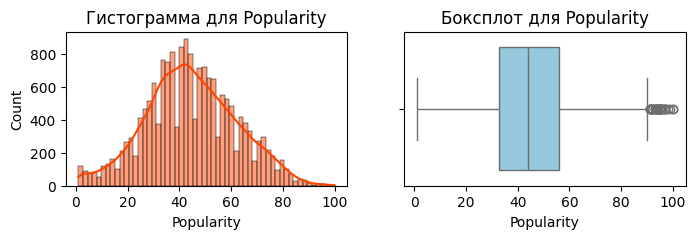

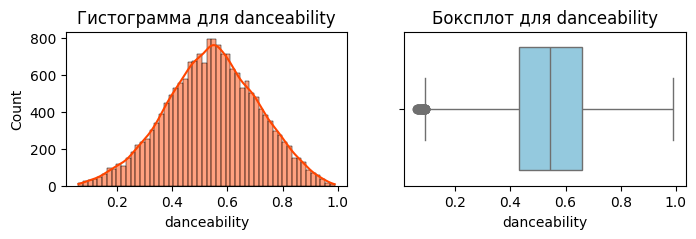

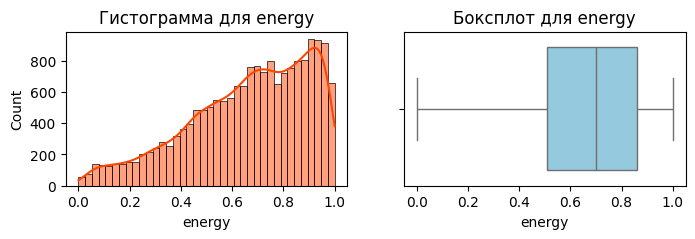

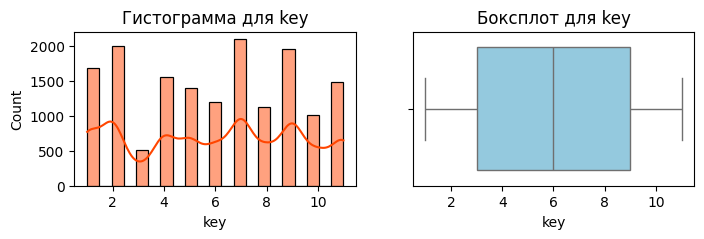

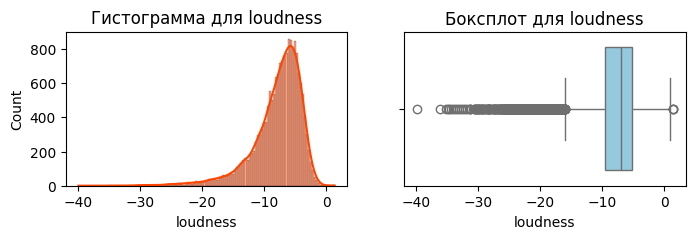

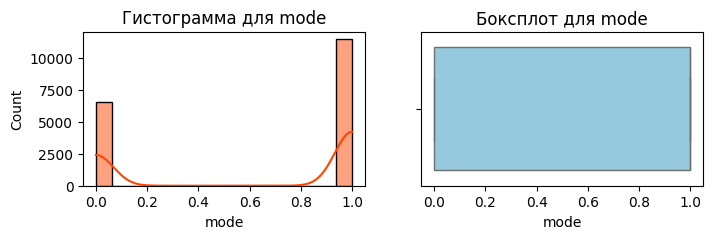

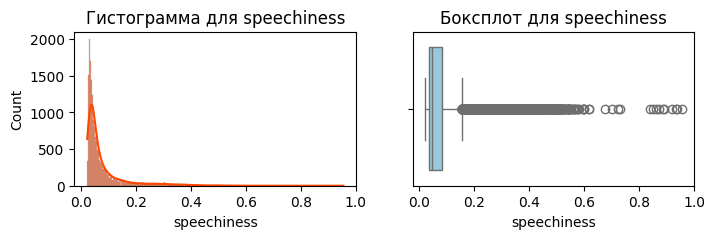

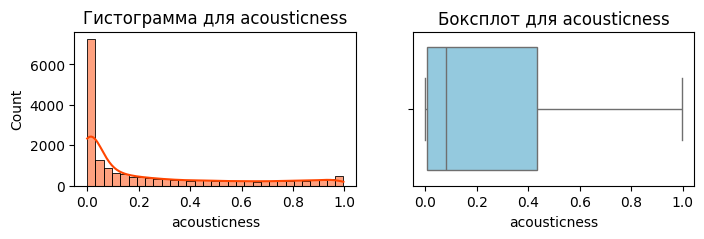

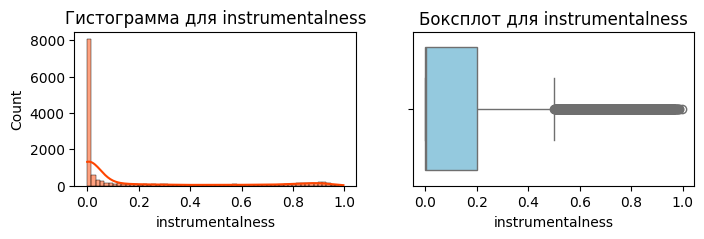

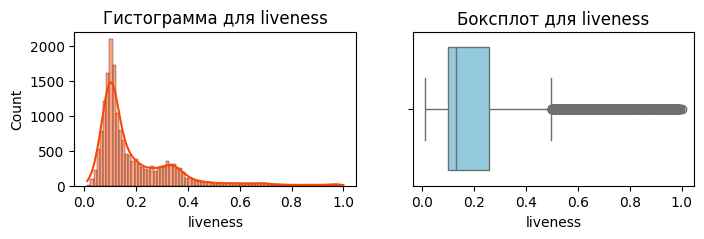

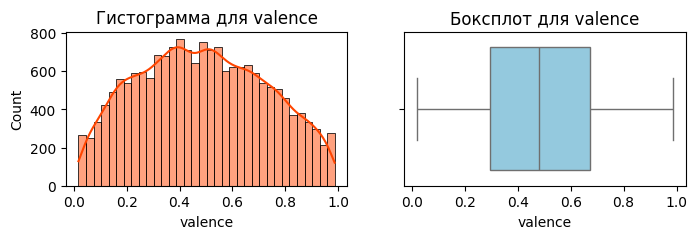

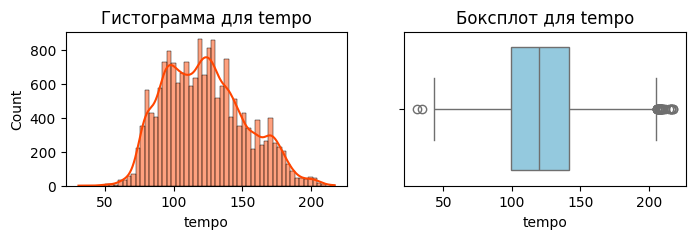

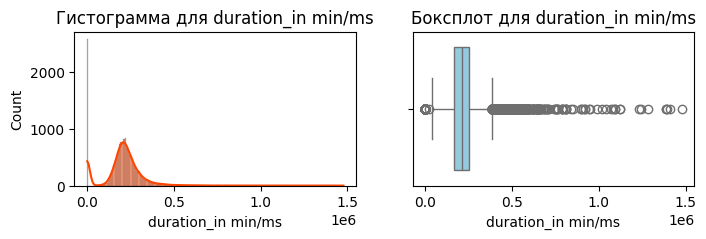

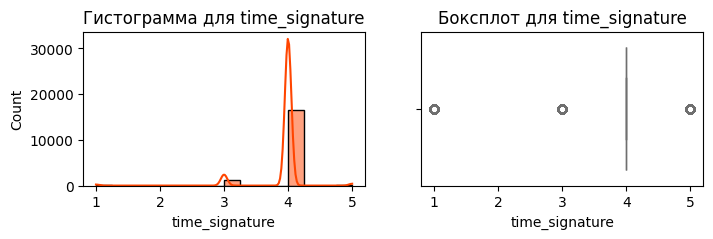

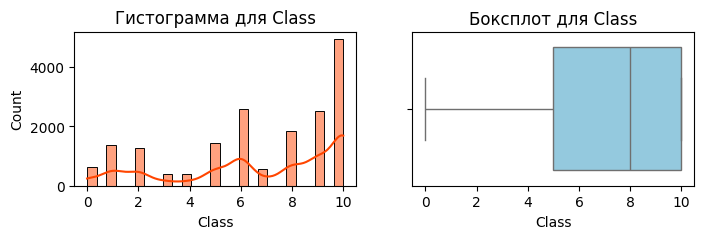

In [7]:
# Распределение числовых признаков

print("Посмотрим на распределение 'числовых' признаков:")
numeric_features = data.select_dtypes(include=['int64', 'float64'])

for column in numeric_features.columns:
    plt.figure(figsize=(8, 2))
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], kde=True, color='orangered', edgecolor='black')
    plt.title(f'Гистограмма для {column}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column], color='skyblue')
    plt.title(f'Боксплот для {column}')

    plt.show()

Предлагаю удалить пару наблюдений, которые выглядят как выбросы.

In [8]:
outliers = [np.argmin(data['loudness']), np.argmin(data['tempo'])]

In [9]:
data = data.drop(outliers, axis=0, inplace=False)

Также, судя по гистограмме для Class, данные у нас **не сбалансированы**, нужно будет это учитывать, подбирая метрики.

Посмотрим на корреляции между переменными:


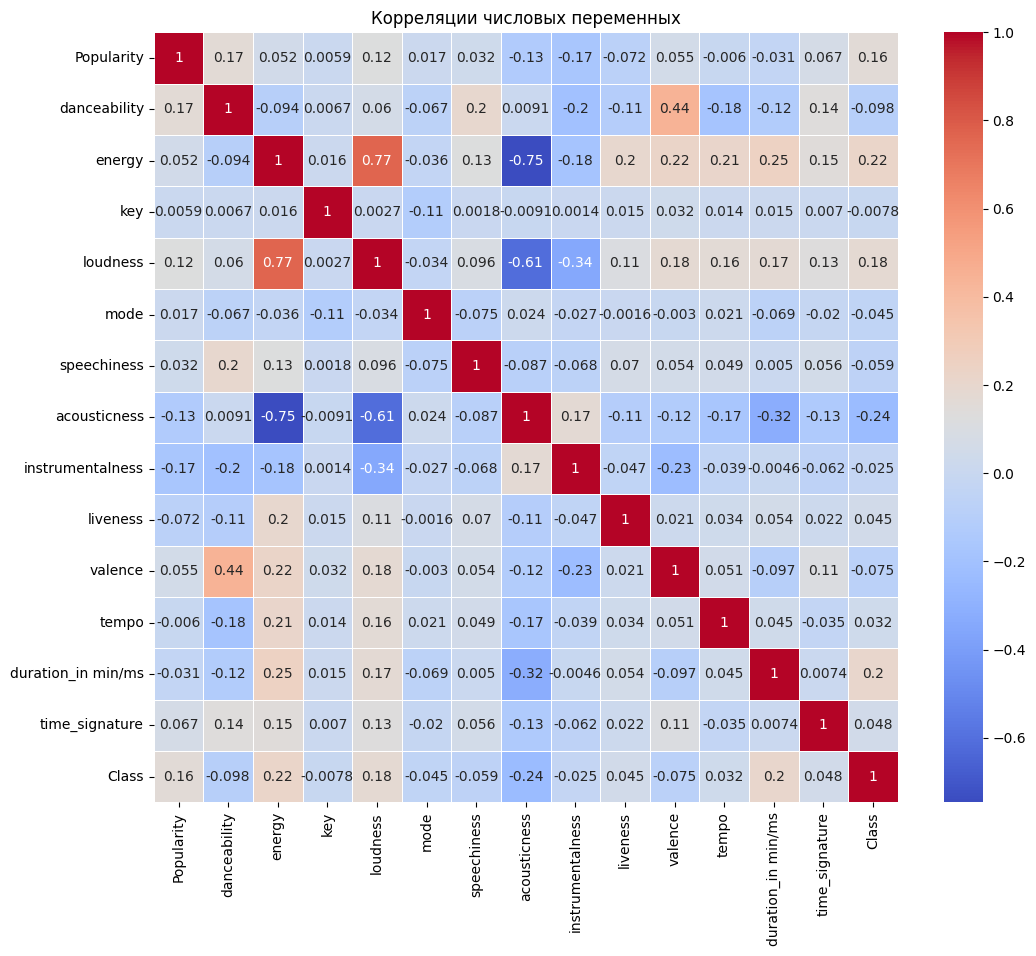

In [10]:
# Корреляции
print("Посмотрим на корреляции между переменными:")
correlation_matrix = numeric_features.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляции числовых переменных')
plt.show()

Можно бы убрать колонку *energy*, т.к. она связана с двумя другими переменными высокой корреляцией. Без неё метрики модели получаются немного выше.

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [23]:
data_processed = data.copy()
data_processed.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [12]:
# 'Artist Name' и 'Track Name' уберём, т.к. по ним странно предсказывать жанр

In [24]:
X = data_processed.drop(['Class', 'energy', 'Artist Name', 'Track Name'], axis=1)
y = data_processed['Class']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [26]:
# Обработаем категориальные и числовые переменные

numeric_features = ['Popularity', 'danceability', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_in min/ms', 'time_signature']

categorical_features = ['key', 'mode', 'time_signature']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop="first"), categorical_features),
        ('num', StandardScaler(), numeric_features),
    ])

In [27]:
# Преобразуем данные

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [28]:
# Определяем гиперпараметры и обучаем модель с использованием GridSearchCV
# Выбрали метрику f1_macro, т.к. работает с небалансированными данными

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7, 10, 12],
    'min_samples_split': [2, 5, 7, 10, 12],
    'min_samples_leaf': [1, 3, 5, 7]
}

tree_classifier = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(tree_classifier, param_grid, scoring='f1_macro', cv=5)
grid_search.fit(X_train_transformed, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший F1: {grid_search.best_score_}")

Лучшие параметры: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Лучший F1: 0.5000848777967881


In [29]:
# Судя по F1, модель выйдет среднего качества
# Обучаем модель на тестовых данных, используя лучшие параметры

best_model = grid_search.best_estimator_
best_model.fit(X_train_transformed, y_train)
best_pred = best_model.predict(X_test_transformed)

In [33]:
# Оцениваем результаты

f1_macro = f1_score(y_test, best_pred, average='macro')
accuracy = accuracy_score(y_test, best_pred)

print(f"F1 на тестовых данных: {f1_macro}")
print(f"Accuracy на тестовых данных: {accuracy}")

F1 на тестовых данных: 0.49313068794367076
Accuracy на тестовых данных: 0.4604056682411781


In [31]:
print("Отчет с основными метриками модели:\n", classification_report(y_test, best_pred))

Отчет с основными метриками модели:
               precision    recall  f1-score   support

           0       0.55      0.72      0.63       126
           1       0.17      0.05      0.07       281
           2       0.34      0.26      0.29       290
           3       0.67      0.51      0.58        71
           4       0.58      0.63      0.60        78
           5       0.61      0.59      0.60       290
           6       0.34      0.28      0.31       517
           7       0.89      0.83      0.86       106
           8       0.56      0.54      0.55       358
           9       0.47      0.43      0.45       527
          10       0.42      0.59      0.49       955

    accuracy                           0.46      3599
   macro avg       0.51      0.49      0.49      3599
weighted avg       0.44      0.46      0.44      3599



In [21]:
# Support: количество экземпляров каждого класса в тестовом наборе данных

# Macro avg: среднее значение по всем классам для каждой метрики (precision, recall, f1)
# Weighted avg: учитывает дисбаланс классов, умножая каждую метрику на долю экземпляров соответствующего класса в общем числе экземпляров
# Accuracy: доля правильных предсказаний по всем классам.

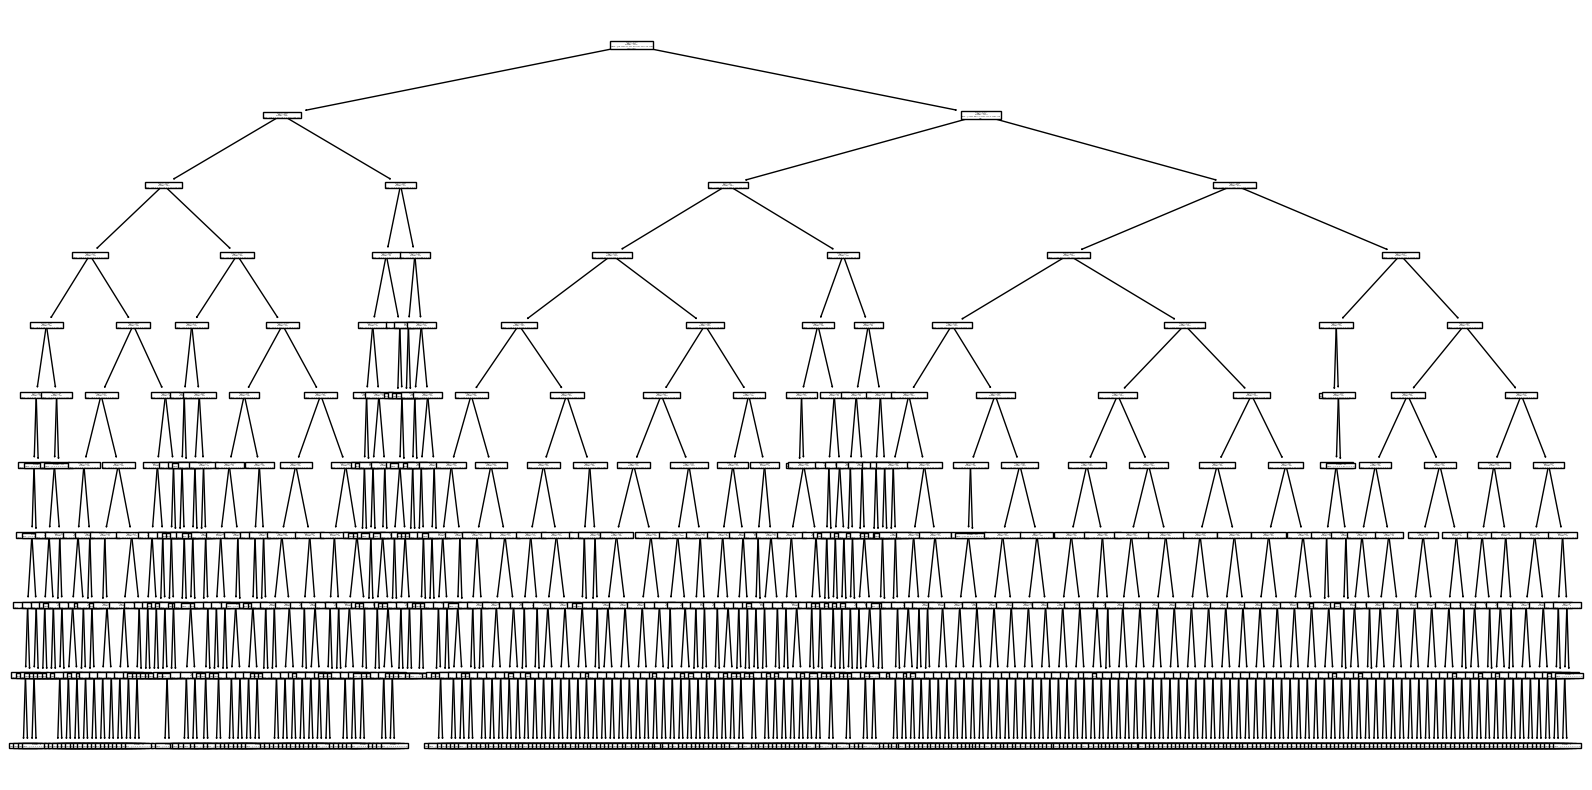

In [32]:
# Напоследок посмотрим на визуализацию нашего дерева

plt.figure(figsize=(20, 10))
tree.plot_tree(best_model)
plt.show()

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.  

  Заполняю это глубокой ночью, так что на ум приходит только база:  
  
1. "Гарри Поттер", потому что ну камон, кто в 11 лет не мечтал получить письмо и убежать от этих магглов

2. "Властелин колец", потому что больше, чем получить письмо из Хогвартса, я мечтала только затусить с Братством кольца (до сих пор мечтаю)

3. "Kono subarashii sekai ni shukufuku wo!" (KonoSuba), потому что раз уж вышла подборка из серии ухода от реальности, то это аниме подходит как нельзя лучше